In [41]:
import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
from data_utils import get_data
import matplotlib.pyplot as plt

In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=100, num_test=50)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2408, 22, 1000) 
y_train: (2408,) 
X_val: (100, 22, 1000) 
y_val: (100,) 
X_test: (50, 22, 1000) 
y_test: (50,) 


In [3]:
# class flatten to connect to FC layer
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H = x.size() # read in N, C, H
        return x.view(N, -1)

In [93]:
# turn x and y into torch type tensor

N_train, C_train, H_train = data.get('X_train').shape
N_val, C_val, H_val = data.get('X_val').shape
N_test, C_test, H_test = data.get('X_test').shape

dtype = torch.FloatTensor

X_train = Variable(torch.Tensor(data.get('X_train'))).type(dtype)
y_train = Variable(torch.Tensor(data.get('y_train'))).type(torch.LongTensor)
X_val = Variable(torch.Tensor(data.get('X_val'))).type(dtype)
y_val = Variable(torch.Tensor(data.get('y_val'))).type(torch.LongTensor)
X_test = Variable(torch.Tensor(data.get('X_test'))).type(dtype)
y_test = Variable(torch.Tensor(data.get('y_test'))).type(torch.LongTensor)

In [94]:
# set up sequential model

model = nn.Sequential(
                      nn.Conv1d(22, 10, kernel_size=12, stride=4),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5),
                      nn.BatchNorm1d(num_features=10),
                      nn.MaxPool1d(kernel_size=4, stride=4),
                      Flatten(),
                      nn.Linear(620, 20),
                      nn.ReLU(inplace=True),
                      nn.Linear(20, 4)
)

model.type(dtype)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [95]:
# train through several iterations
num_epoch = 100
batch_size = 80
step = np.arange(0,N_train,batch_size)
#step = np.append(step,N_train) #discard some data

loss_his = []
train_accu_his = []
val_accu_his = []

for epoch in range(num_epoch):
    for t in range(step.shape[0]-1):

        # calculate training loss
        y_train_pred = model(X_train[step[t]:step[t+1],:,:])
        loss = loss_fn(y_train_pred, y_train[step[t]:step[t+1]])

        # backpropagation
        model.zero_grad()
        loss.backward()

        # update parameters
        optimizer.step()
        
    # calculate predicted value for validation
    y_val_pred = model(X_val)

    # training loss
    print('Epoch ', epoch, ', loss is ', loss.data.numpy())
    _, y_pred = torch.max(y_train_pred,1)
    loss_his.append(loss.data.numpy())
    
    # training accuracy
    train_accu = np.mean(y_pred.data.numpy() == 
                                       y_train.data[step[t]:step[t+1]].numpy())
    print('Training accuracy', train_accu)
    train_accu_his.append(train_accu)

    # validation accuracy    
    _, y_pred = torch.max(y_val_pred,1)
    val_accu = np.mean(y_pred.data.numpy() ==  y_val.data.numpy())
    print('Validation accuracy', val_accu, '\n')   
    val_accu_his.append(val_accu)

Epoch  0 , loss is  [ 1.3916899]
Training accuracy 0.2375
Validation accuracy 0.26 

Epoch  1 , loss is  [ 1.37960505]
Training accuracy 0.2625
Validation accuracy 0.28 

Epoch  2 , loss is  [ 1.38793576]
Training accuracy 0.3
Validation accuracy 0.26 

Epoch  3 , loss is  [ 1.37578607]
Training accuracy 0.3
Validation accuracy 0.32 

Epoch  4 , loss is  [ 1.3439728]
Training accuracy 0.35
Validation accuracy 0.23 

Epoch  5 , loss is  [ 1.3512131]
Training accuracy 0.3375
Validation accuracy 0.23 

Epoch  6 , loss is  [ 1.33631802]
Training accuracy 0.375
Validation accuracy 0.31 

Epoch  7 , loss is  [ 1.33932757]
Training accuracy 0.325
Validation accuracy 0.31 

Epoch  8 , loss is  [ 1.28917289]
Training accuracy 0.475
Validation accuracy 0.26 

Epoch  9 , loss is  [ 1.29345179]
Training accuracy 0.45
Validation accuracy 0.3 

Epoch  10 , loss is  [ 1.3039968]
Training accuracy 0.4
Validation accuracy 0.35 

Epoch  11 , loss is  [ 1.26906168]
Training accuracy 0.4875
Validation acc

Epoch  96 , loss is  [ 0.64680398]
Training accuracy 0.7625
Validation accuracy 0.56 

Epoch  97 , loss is  [ 0.61892861]
Training accuracy 0.7625
Validation accuracy 0.52 

Epoch  98 , loss is  [ 0.71597588]
Training accuracy 0.6875
Validation accuracy 0.61 

Epoch  99 , loss is  [ 0.60675442]
Training accuracy 0.775
Validation accuracy 0.53 



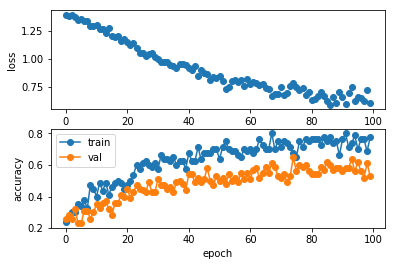

In [96]:
# plot training and validation history
plt.subplot(2, 1, 1)
plt.plot(loss_his, 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(train_accu_his, '-o')
plt.plot(val_accu_his, '-o')
plt.legend(['train','val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

In [97]:
# test set
y_test_pred = model(X_test)
  
_, y_pred = torch.max(y_test_pred,1)
test_accu = np.mean(y_pred.data.numpy() ==  y_test.data.numpy())
print('Test accuracy', test_accu, '\n')   

Test accuracy 0.68 

